#### Load library

In [1]:
import os
import time
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score
from torchvision import models

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = "/content/drive/MyDrive/Colab Notebooks/augmented_dataset"

In [5]:
# 정규화 및 transform 설정
normalize = transforms.Normalize(mean=[0.5184, 0.4233, 0.3783],
                                 std=[0.2486, 0.2229, 0.2204])

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

# 경로
train_dir = data_path + '/train'
test_dir = data_path + '/test'

# 전체 데이터셋 불러오기
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# 클래스 라벨 매핑
class_to_idx = full_train_dataset.class_to_idx
print("클래스 라벨 매핑:", class_to_idx)  # 예: {'fake': 0, 'real': 1}

# 각 클래스별 valid 인덱스 500개씩 추출
targets = np.array(full_train_dataset.targets)
valid_idx = []

for class_id in np.unique(targets):
    class_indices = np.where(targets == class_id)[0]
    selected = np.random.choice(class_indices, 500, replace=False)
    valid_idx.extend(selected)

# train 인덱스 = 전체 - valid
valid_idx = set(valid_idx)
all_idx = set(range(len(full_train_dataset)))
train_idx = list(all_idx - valid_idx)
valid_idx = list(valid_idx)

# Subset으로 나누기
train_dataset = Subset(full_train_dataset, train_idx)
valid_dataset = Subset(full_train_dataset, valid_idx)

# DataLoader 설정
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# 각 로더 길이 출력
print(f"Train Loader Length: {len(train_loader)} batches ({len(train_dataset)} samples)")
print(f"Valid Loader Length: {len(valid_loader)} batches ({len(valid_dataset)} samples)")
print(f"Test Loader Length:  {len(test_loader)} batches ({len(test_dataset)} samples)")


클래스 라벨 매핑: {'fake': 0, 'real': 1}
Train Loader Length: 63 batches (4000 samples)
Valid Loader Length: 16 batches (1000 samples)
Test Loader Length:  16 batches (1000 samples)


#### train & test

In [6]:
# Traninig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, dataloader, device, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)                        # (batch, 1)
        loss = criterion(outputs, labels)              # BCEWithLogitsLoss
        loss.backward()
        optimizer.step()


        total_loss += loss.item()
        preds = torch.sigmoid(outputs) > 0.5           # threshold
        correct += (preds == labels.bool()).sum().item()
        total += labels.size(0)

    return correct / total, total_loss / len(dataloader)

def test(model, dataloader, device, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels.bool()).sum().item()
            total += labels.size(0)

    return correct / total, total_loss / len(dataloader)

#### evaluate

In [7]:
def plot_loss_accuracy(logs):
    import matplotlib.pyplot as plt

    epochs = range(1, len(logs['train_loss']) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, logs['train_loss'], label='Train Loss')
    plt.plot(epochs, logs['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, logs['train_acc'], label='Train Acc')
    plt.plot(epochs, logs['val_acc'], label='Validation Acc')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [8]:
def compute_metrics(model, dataloader, device):
    import torch
    from sklearn.metrics import confusion_matrix, classification_report

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy().astype(int)
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.numpy())

    report = classification_report(all_labels, all_preds, target_names=['fake', 'real'], output_dict=True)
    acc = report['accuracy']
    recall = report['real']['recall']
    f1 = report['real']['f1-score']
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    specificity = tn / (tn + fp)

    print(f"Accuracy: {acc:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Specificity: {specificity:.4f}")


In [9]:
def plot_confusion_matrix(model, dataloader, device):
    import torch
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy().astype(int)
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['fake', 'real'], yticklabels=['fake', 'real'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [10]:
def plot_roc_curve(model, dataloader, device):
    import torch
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc

    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            y_scores.extend(probs.cpu().numpy())
            y_true.extend(labels.numpy())

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc='lower right')
    plt.show()


In [11]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total}")
    print(f"Trainable Parameters: {trainable}")


In [12]:
def measure_inference_time_per_image(model, dataloader, device, max_images=100):
    import time
    model.eval()
    total_images = 0
    total_time = 0.0

    with torch.no_grad():
        for images, _ in dataloader:
            batch_size = images.size(0)
            images = images.to(device)

            start_time = time.time()
            _ = model(images)
            elapsed = time.time() - start_time

            total_images += batch_size
            total_time += elapsed

            if total_images >= max_images:
                break

    avg_time_per_image = total_time / total_images
    print(f"Average inference time per image (on {total_images} images): {avg_time_per_image:.6f} seconds")


#### FC만 학습

In [13]:
# EfficientNet-B0
def get_efficientnet_b0_fc_only():
    model = models.efficientnet_b0(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

    return model

In [24]:
from tqdm import tqdm
import os
import numpy as np

EPOCHS = 100
logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

criterion = nn.BCEWithLogitsLoss()
patience = 5
counter = 0
best_loss = np.inf

model = get_efficientnet_b0_fc_only().to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(model, train_loader, device, criterion, optimizer)
    val_acc, val_loss = test(model, valid_loader, device, criterion)

    print(f"[Epoch {epoch}] train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f} | "
          f"val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}", flush=True)

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    lr_scheduler.step()

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/efficientnet_b0_fc_only_best.pth")
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        # test_acc, test_loss = test(model, test_loader, device, criterion)
        # print(f"Final Test Accuracy: {test_acc:.4f}")
        break


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 0] train_loss = 0.6584, train_acc = 0.6118 | val_loss = 0.6120, val_acc = 0.7010


  1%|          | 1/100 [00:08<14:45,  8.94s/it]

[Epoch 1] train_loss = 0.5957, train_acc = 0.6995 | val_loss = 0.5756, val_acc = 0.7150


  2%|▏         | 2/100 [00:17<14:32,  8.90s/it]

[Epoch 2] train_loss = 0.5718, train_acc = 0.7163 | val_loss = 0.5566, val_acc = 0.7230


  3%|▎         | 3/100 [00:26<14:31,  8.98s/it]

[Epoch 3] train_loss = 0.5527, train_acc = 0.7292 | val_loss = 0.5456, val_acc = 0.7320


  4%|▍         | 4/100 [00:35<14:24,  9.00s/it]

[Epoch 4] train_loss = 0.5362, train_acc = 0.7425 | val_loss = 0.5400, val_acc = 0.7390


  5%|▌         | 5/100 [00:44<14:16,  9.02s/it]

[Epoch 5] train_loss = 0.5354, train_acc = 0.7402 | val_loss = 0.5378, val_acc = 0.7380


  6%|▌         | 6/100 [00:53<14:00,  8.94s/it]

[Epoch 6] train_loss = 0.5234, train_acc = 0.7468 | val_loss = 0.5315, val_acc = 0.7370


  7%|▋         | 7/100 [01:02<13:53,  8.96s/it]

[Epoch 7] train_loss = 0.5136, train_acc = 0.7540 | val_loss = 0.5282, val_acc = 0.7450


  8%|▊         | 8/100 [01:11<13:44,  8.96s/it]

[Epoch 8] train_loss = 0.5080, train_acc = 0.7562 | val_loss = 0.5204, val_acc = 0.7500


  9%|▉         | 9/100 [01:21<13:45,  9.08s/it]

[Epoch 9] train_loss = 0.5041, train_acc = 0.7632 | val_loss = 0.5201, val_acc = 0.7480


 10%|█         | 10/100 [01:30<13:40,  9.11s/it]

[Epoch 10] train_loss = 0.4994, train_acc = 0.7628 | val_loss = 0.5159, val_acc = 0.7540


 11%|█         | 11/100 [01:39<13:31,  9.12s/it]

[Epoch 11] train_loss = 0.4969, train_acc = 0.7660 | val_loss = 0.5183, val_acc = 0.7500


 12%|█▏        | 12/100 [01:48<13:21,  9.10s/it]

[Epoch 12] train_loss = 0.4902, train_acc = 0.7650 | val_loss = 0.5087, val_acc = 0.7530


 13%|█▎        | 13/100 [01:57<13:13,  9.12s/it]

[Epoch 13] train_loss = 0.4865, train_acc = 0.7662 | val_loss = 0.5057, val_acc = 0.7600


 14%|█▍        | 14/100 [02:06<13:10,  9.19s/it]

[Epoch 14] train_loss = 0.4879, train_acc = 0.7702 | val_loss = 0.5070, val_acc = 0.7570


 15%|█▌        | 15/100 [02:15<12:55,  9.12s/it]

[Epoch 15] train_loss = 0.4856, train_acc = 0.7715 | val_loss = 0.5047, val_acc = 0.7650


 16%|█▌        | 16/100 [02:25<12:55,  9.23s/it]

[Epoch 16] train_loss = 0.4813, train_acc = 0.7752 | val_loss = 0.5015, val_acc = 0.7710


 17%|█▋        | 17/100 [02:34<12:46,  9.23s/it]

[Epoch 17] train_loss = 0.4752, train_acc = 0.7833 | val_loss = 0.5018, val_acc = 0.7670


 18%|█▊        | 18/100 [02:43<12:31,  9.16s/it]

[Epoch 18] train_loss = 0.4796, train_acc = 0.7750 | val_loss = 0.5082, val_acc = 0.7600


 19%|█▉        | 19/100 [02:52<12:17,  9.11s/it]

[Epoch 19] train_loss = 0.4681, train_acc = 0.7820 | val_loss = 0.4962, val_acc = 0.7730


 20%|██        | 20/100 [03:01<12:12,  9.15s/it]

[Epoch 20] train_loss = 0.4731, train_acc = 0.7788 | val_loss = 0.5030, val_acc = 0.7620


 21%|██        | 21/100 [03:10<11:56,  9.07s/it]

[Epoch 21] train_loss = 0.4699, train_acc = 0.7785 | val_loss = 0.4996, val_acc = 0.7720


 22%|██▏       | 22/100 [03:20<11:52,  9.13s/it]

[Epoch 22] train_loss = 0.4610, train_acc = 0.7837 | val_loss = 0.5003, val_acc = 0.7660


 23%|██▎       | 23/100 [03:29<11:44,  9.14s/it]

[Epoch 23] train_loss = 0.4658, train_acc = 0.7853 | val_loss = 0.4949, val_acc = 0.7760


 24%|██▍       | 24/100 [03:38<11:32,  9.11s/it]

[Epoch 24] train_loss = 0.4632, train_acc = 0.7805 | val_loss = 0.4969, val_acc = 0.7660


 25%|██▌       | 25/100 [03:46<11:13,  8.97s/it]

[Epoch 25] train_loss = 0.4599, train_acc = 0.7850 | val_loss = 0.4945, val_acc = 0.7730


 26%|██▌       | 26/100 [03:55<10:57,  8.89s/it]

[Epoch 26] train_loss = 0.4613, train_acc = 0.7817 | val_loss = 0.4961, val_acc = 0.7710


 27%|██▋       | 27/100 [04:04<10:42,  8.81s/it]

[Epoch 27] train_loss = 0.4598, train_acc = 0.7900 | val_loss = 0.4949, val_acc = 0.7660


 28%|██▊       | 28/100 [04:12<10:32,  8.78s/it]

[Epoch 28] train_loss = 0.4629, train_acc = 0.7780 | val_loss = 0.4921, val_acc = 0.7750


 29%|██▉       | 29/100 [04:21<10:26,  8.83s/it]

[Epoch 29] train_loss = 0.4533, train_acc = 0.7933 | val_loss = 0.4974, val_acc = 0.7640


 30%|███       | 30/100 [04:30<10:16,  8.81s/it]

[Epoch 30] train_loss = 0.4585, train_acc = 0.7885 | val_loss = 0.4972, val_acc = 0.7620


 31%|███       | 31/100 [04:39<10:11,  8.86s/it]

[Epoch 31] train_loss = 0.4533, train_acc = 0.7890 | val_loss = 0.4995, val_acc = 0.7600


 32%|███▏      | 32/100 [04:48<09:55,  8.76s/it]

[Epoch 32] train_loss = 0.4515, train_acc = 0.7970 | val_loss = 0.4913, val_acc = 0.7710


 33%|███▎      | 33/100 [04:56<09:47,  8.77s/it]

[Epoch 33] train_loss = 0.4461, train_acc = 0.7947 | val_loss = 0.4904, val_acc = 0.7730


 34%|███▍      | 34/100 [05:05<09:42,  8.82s/it]

[Epoch 34] train_loss = 0.4498, train_acc = 0.7910 | val_loss = 0.4876, val_acc = 0.7760


 35%|███▌      | 35/100 [05:14<09:34,  8.84s/it]

[Epoch 35] train_loss = 0.4420, train_acc = 0.7990 | val_loss = 0.4908, val_acc = 0.7740


 36%|███▌      | 36/100 [05:23<09:27,  8.87s/it]

[Epoch 36] train_loss = 0.4497, train_acc = 0.7950 | val_loss = 0.4891, val_acc = 0.7710


 37%|███▋      | 37/100 [05:32<09:17,  8.86s/it]

[Epoch 37] train_loss = 0.4524, train_acc = 0.7855 | val_loss = 0.4872, val_acc = 0.7780


 38%|███▊      | 38/100 [05:41<09:11,  8.90s/it]

[Epoch 38] train_loss = 0.4473, train_acc = 0.7903 | val_loss = 0.4899, val_acc = 0.7720


 39%|███▉      | 39/100 [05:50<08:57,  8.81s/it]

[Epoch 39] train_loss = 0.4498, train_acc = 0.7973 | val_loss = 0.4873, val_acc = 0.7760


 40%|████      | 40/100 [05:59<08:51,  8.86s/it]

[Epoch 40] train_loss = 0.4536, train_acc = 0.7923 | val_loss = 0.4862, val_acc = 0.7730


 41%|████      | 41/100 [06:07<08:41,  8.84s/it]

[Epoch 41] train_loss = 0.4503, train_acc = 0.7857 | val_loss = 0.4873, val_acc = 0.7740


 42%|████▏     | 42/100 [06:16<08:30,  8.81s/it]

[Epoch 42] train_loss = 0.4519, train_acc = 0.7840 | val_loss = 0.4905, val_acc = 0.7760


 43%|████▎     | 43/100 [06:25<08:20,  8.79s/it]

[Epoch 43] train_loss = 0.4488, train_acc = 0.7917 | val_loss = 0.4840, val_acc = 0.7700


 44%|████▍     | 44/100 [06:34<08:15,  8.84s/it]

[Epoch 44] train_loss = 0.4490, train_acc = 0.7983 | val_loss = 0.4871, val_acc = 0.7780


 45%|████▌     | 45/100 [06:43<08:06,  8.84s/it]

[Epoch 45] train_loss = 0.4387, train_acc = 0.8023 | val_loss = 0.4881, val_acc = 0.7700


 46%|████▌     | 46/100 [06:52<08:00,  8.89s/it]

[Epoch 46] train_loss = 0.4476, train_acc = 0.7873 | val_loss = 0.4881, val_acc = 0.7690


 47%|████▋     | 47/100 [07:00<07:48,  8.84s/it]

[Epoch 47] train_loss = 0.4434, train_acc = 0.7955 | val_loss = 0.4825, val_acc = 0.7760


 48%|████▊     | 48/100 [07:09<07:40,  8.85s/it]

[Epoch 48] train_loss = 0.4435, train_acc = 0.8005 | val_loss = 0.4871, val_acc = 0.7710


 49%|████▉     | 49/100 [07:18<07:29,  8.81s/it]

[Epoch 49] train_loss = 0.4431, train_acc = 0.7997 | val_loss = 0.4864, val_acc = 0.7730


 50%|█████     | 50/100 [07:27<07:20,  8.81s/it]

[Epoch 50] train_loss = 0.4488, train_acc = 0.7847 | val_loss = 0.4882, val_acc = 0.7700


 51%|█████     | 51/100 [07:36<07:14,  8.86s/it]

[Epoch 51] train_loss = 0.4440, train_acc = 0.7977 | val_loss = 0.4878, val_acc = 0.7720


 52%|█████▏    | 52/100 [07:45<07:04,  8.84s/it]

[Epoch 52] train_loss = 0.4389, train_acc = 0.7997 | val_loss = 0.4794, val_acc = 0.7830


 53%|█████▎    | 53/100 [07:53<06:54,  8.82s/it]

[Epoch 53] train_loss = 0.4429, train_acc = 0.7945 | val_loss = 0.4855, val_acc = 0.7740


 54%|█████▍    | 54/100 [08:02<06:44,  8.80s/it]

[Epoch 54] train_loss = 0.4417, train_acc = 0.7977 | val_loss = 0.4845, val_acc = 0.7730


 55%|█████▌    | 55/100 [08:11<06:39,  8.87s/it]

[Epoch 55] train_loss = 0.4385, train_acc = 0.8033 | val_loss = 0.4853, val_acc = 0.7750


 56%|█████▌    | 56/100 [08:20<06:32,  8.91s/it]

[Epoch 56] train_loss = 0.4377, train_acc = 0.8045 | val_loss = 0.4818, val_acc = 0.7740


 57%|█████▋    | 57/100 [08:29<06:20,  8.85s/it]

[Epoch 57] train_loss = 0.4412, train_acc = 0.7873 | val_loss = 0.4839, val_acc = 0.7750


 57%|█████▋    | 57/100 [08:38<06:30,  9.09s/it]

Early stopping triggered


Final Test Accuracy: 0.7750


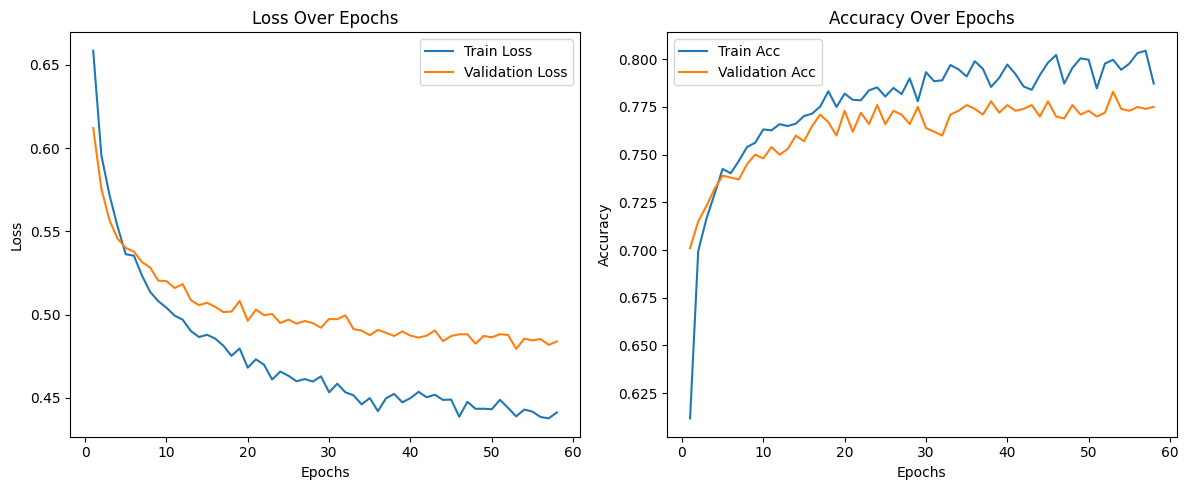

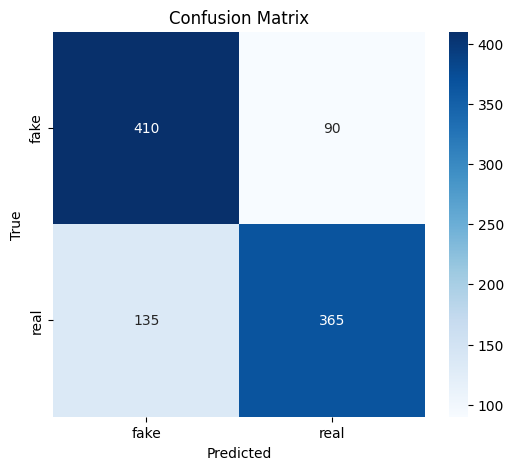

Accuracy: 0.7750
Recall (Sensitivity): 0.7300
F1-score: 0.7644
Specificity: 0.8200


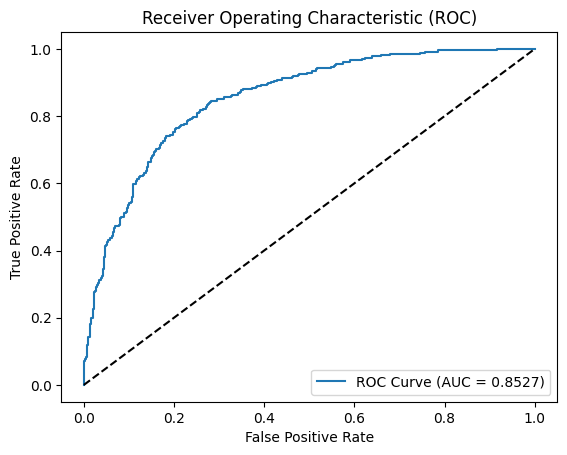

Total Parameters: 4008829
Trainable Parameters: 1281
Average inference time per image (on 128 images): 0.000266 seconds


In [25]:
# 모델 정의
model = get_efficientnet_b0_fc_only().to(device)

# 저장된 파라미터 로드
model.load_state_dict(torch.load("checkpoints/efficientnet_b0_fc_only_best.pth", map_location=device))

test_acc, test_loss = test(model, test_loader, device, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Accuracy, Loss 그래프
plot_loss_accuracy(logs)

# Confusion Matrix
plot_confusion_matrix(model, test_loader, device)

# 정밀도/재현율/특이도 등
compute_metrics(model, test_loader, device)

# ROC 곡선
plot_roc_curve(model, test_loader, device)

# 파라미터 개수
count_parameters(model)

# 추론 시간
measure_inference_time_per_image(model, test_loader, device)

#### FC + BN

In [26]:
def get_efficientnet_b0_fc_bn():
    model = models.efficientnet_b0(pretrained=True)

    for name, module in model.named_modules():
        if isinstance(module, nn.BatchNorm2d):
            for param in module.parameters():
                param.requires_grad = True
        else:
            for param in module.parameters():
                param.requires_grad = False

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 1)

    for param in model.classifier[1].parameters():
        param.requires_grad = True

    return model


In [38]:
from tqdm import tqdm
import os
import numpy as np

EPOCHS = 100
logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

criterion = nn.BCEWithLogitsLoss()
patience = 5
counter = 0
best_loss = np.inf

model = get_efficientnet_b0_fc_bn().to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(model, train_loader, device, criterion, optimizer)
    val_acc, val_loss = test(model, valid_loader, device, criterion)

    print(f"[Epoch {epoch}] train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f} | "
          f"val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}", flush=True)

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    lr_scheduler.step()

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/efficientnet_b0_fc_bn_best.pth")
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        # test_acc, test_loss = test(model, test_loader, device, criterion)
        # print(f"Final Test Accuracy: {test_acc:.4f}")
        break


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 0] train_loss = 0.5111, train_acc = 0.7420 | val_loss = 0.5530, val_acc = 0.7500


  1%|          | 1/100 [00:09<15:30,  9.40s/it]

[Epoch 1] train_loss = 0.2732, train_acc = 0.8895 | val_loss = 0.7775, val_acc = 0.6810


  2%|▏         | 2/100 [00:18<15:19,  9.38s/it]

[Epoch 2] train_loss = 0.1802, train_acc = 0.9280 | val_loss = 0.3052, val_acc = 0.8750


  3%|▎         | 3/100 [00:28<15:16,  9.44s/it]

[Epoch 3] train_loss = 0.1451, train_acc = 0.9445 | val_loss = 0.2893, val_acc = 0.8850


  4%|▍         | 4/100 [00:37<15:11,  9.50s/it]

[Epoch 4] train_loss = 0.0928, train_acc = 0.9643 | val_loss = 0.3197, val_acc = 0.8860


  5%|▌         | 5/100 [00:47<14:59,  9.47s/it]

[Epoch 5] train_loss = 0.0793, train_acc = 0.9705 | val_loss = 0.2755, val_acc = 0.9100


  6%|▌         | 6/100 [00:56<14:43,  9.40s/it]

[Epoch 6] train_loss = 0.0889, train_acc = 0.9698 | val_loss = 0.3143, val_acc = 0.8980


  7%|▋         | 7/100 [01:05<14:34,  9.41s/it]

[Epoch 7] train_loss = 0.0868, train_acc = 0.9643 | val_loss = 0.6654, val_acc = 0.8420


  8%|▊         | 8/100 [01:15<14:18,  9.33s/it]

[Epoch 8] train_loss = 0.1009, train_acc = 0.9610 | val_loss = 0.3298, val_acc = 0.9010


  9%|▉         | 9/100 [01:24<14:09,  9.34s/it]

[Epoch 9] train_loss = 0.0591, train_acc = 0.9785 | val_loss = 0.6623, val_acc = 0.8260


 10%|█         | 10/100 [01:33<13:54,  9.27s/it]

[Epoch 10] train_loss = 0.0608, train_acc = 0.9778 | val_loss = 0.3212, val_acc = 0.9000


 10%|█         | 10/100 [01:42<15:26, 10.29s/it]

Early stopping triggered


Final Test Accuracy: 0.9020


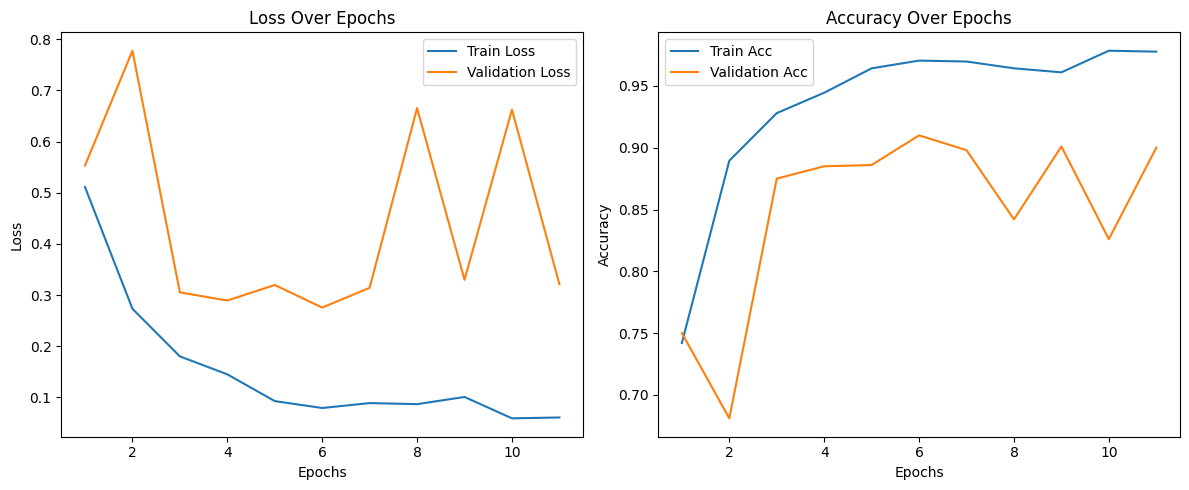

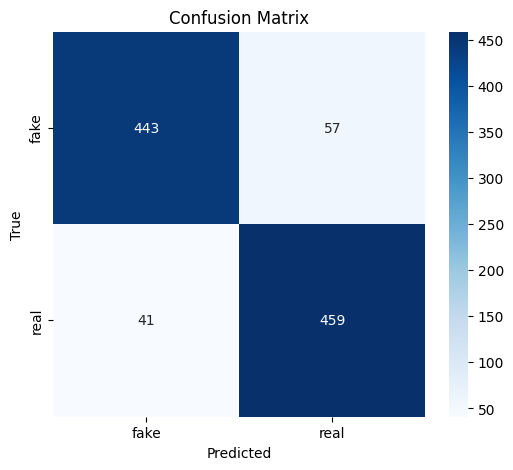

Accuracy: 0.9020
Recall (Sensitivity): 0.9180
F1-score: 0.9035
Specificity: 0.8860


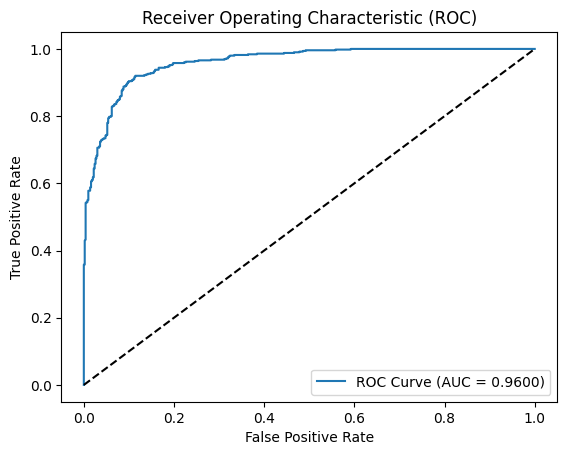

Total Parameters: 4008829
Trainable Parameters: 43297
Average inference time per image (on 128 images): 0.000260 seconds


In [40]:
# 모델 정의
model = get_efficientnet_b0_fc_bn().to(device)

# 저장된 파라미터 로드
model.load_state_dict(torch.load("checkpoints/efficientnet_b0_fc_bn_best.pth", map_location=device))

test_acc, test_loss = test(model, test_loader, device, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Accuracy, Loss 그래프
plot_loss_accuracy(logs)

# Confusion Matrix
plot_confusion_matrix(model, test_loader, device)

# 정밀도/재현율/특이도 등
compute_metrics(model, test_loader, device)

# ROC 곡선
plot_roc_curve(model, test_loader, device)

# 파라미터 개수
count_parameters(model)

# 추론 시간
measure_inference_time_per_image(model, test_loader, device)

#### 학습 X - 출력층 노드 개수만 변환

In [41]:
def get_efficientnet_b0_zeroshot():
    model = models.efficientnet_b0(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 1)

    for param in model.classifier[1].parameters():
        param.requires_grad = True

    return model


In [42]:
from tqdm import tqdm
import os
import numpy as np

EPOCHS = 100
logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

best_loss = np.inf

model = get_efficientnet_b0_zeroshot().to(device)

test_acc, test_loss = test(model, test_loader, device, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Final Test Accuracy: 0.5390


Final Test Accuracy: 0.5390


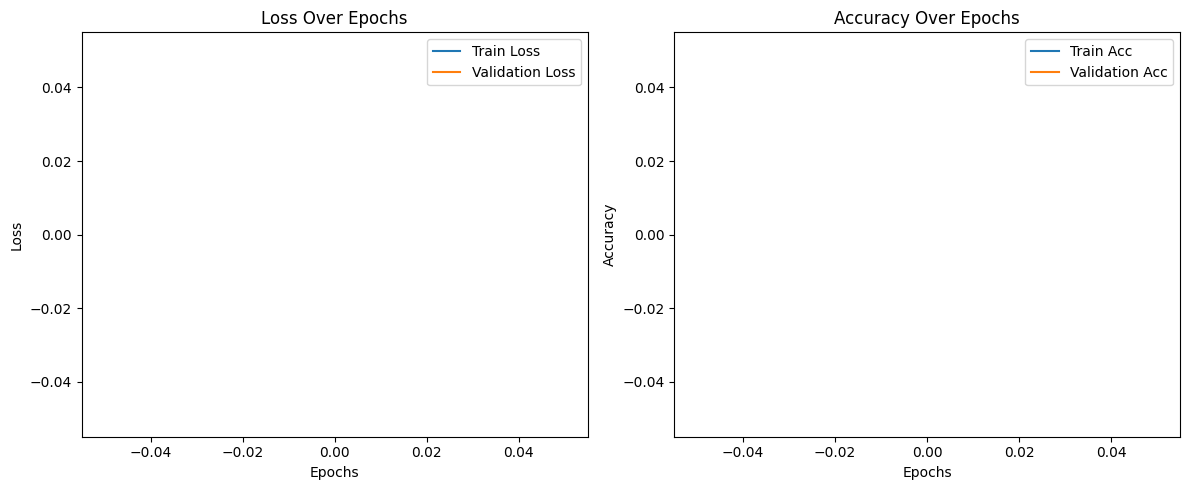

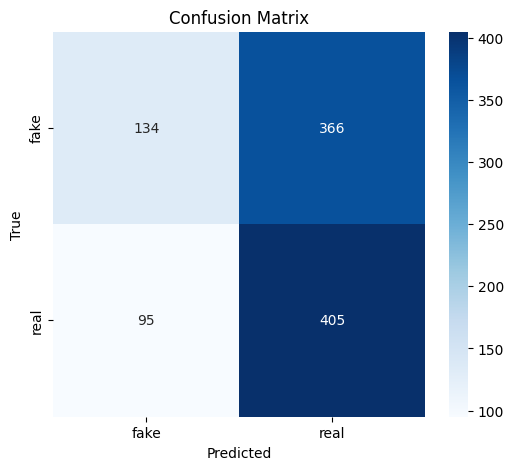

Accuracy: 0.5390
Recall (Sensitivity): 0.8100
F1-score: 0.6373
Specificity: 0.2680


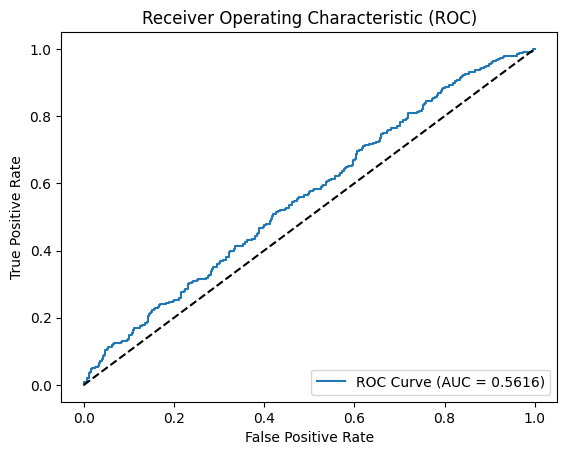

Total Parameters: 4008829
Trainable Parameters: 1281
Average inference time per image (on 128 images): 0.000265 seconds


In [43]:
test_acc, test_loss = test(model, test_loader, device, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Accuracy, Loss 그래프
plot_loss_accuracy(logs)

# Confusion Matrix
plot_confusion_matrix(model, test_loader, device)

# 정밀도/재현율/특이도 등
compute_metrics(model, test_loader, device)

# ROC 곡선
plot_roc_curve(model, test_loader, device)

# 파라미터 개수
count_parameters(model)

# 추론 시간
measure_inference_time_per_image(model, test_loader, device)

#### 상위 블록만 학습

In [44]:
def get_efficientnet_b0_partial_tune(n_blocks=3):
    model = models.efficientnet_b0(pretrained=True)

    for param in model.features.parameters():
        param.requires_grad = False

    # features 내부 마지막 n_blocks(3)만 fine-tune
    total_blocks = list(model.features.children())
    for block in total_blocks[-n_blocks:]:
        for param in block.parameters():
            param.requires_grad = True

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 1)

    for param in model.classifier[1].parameters():
        param.requires_grad = True

    return model

In [61]:
from tqdm import tqdm
import os
import numpy as np

EPOCHS = 100
logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

criterion = nn.BCEWithLogitsLoss()
patience = 5
counter = 0
best_loss = np.inf

model = get_efficientnet_b0_fc_bn().to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(model, train_loader, device, criterion, optimizer)
    val_acc, val_loss = test(model, valid_loader, device, criterion)

    print(f"[Epoch {epoch}] train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f} | "
          f"val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}", flush=True)

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    lr_scheduler.step()

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/efficientnet_b0_partial_3blocks_best.pth")
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        # test_acc, test_loss = test(model, test_loader, device, criterion)
        # print(f"Final Test Accuracy: {test_acc:.4f}")
        break


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 0] train_loss = 0.5051, train_acc = 0.7462 | val_loss = 0.8851, val_acc = 0.6240


  1%|          | 1/100 [00:08<14:31,  8.80s/it]

[Epoch 1] train_loss = 0.2865, train_acc = 0.8822 | val_loss = 0.5029, val_acc = 0.7880


  2%|▏         | 2/100 [00:18<14:59,  9.18s/it]

[Epoch 2] train_loss = 0.2097, train_acc = 0.9177 | val_loss = 0.3422, val_acc = 0.8660


  3%|▎         | 3/100 [00:27<14:52,  9.20s/it]

[Epoch 3] train_loss = 0.1349, train_acc = 0.9510 | val_loss = 0.3181, val_acc = 0.8720


  4%|▍         | 4/100 [00:36<14:49,  9.27s/it]

[Epoch 4] train_loss = 0.1219, train_acc = 0.9543 | val_loss = 0.2937, val_acc = 0.8940


  5%|▌         | 5/100 [00:46<14:41,  9.28s/it]

[Epoch 5] train_loss = 0.1030, train_acc = 0.9617 | val_loss = 1.2912, val_acc = 0.7100


  6%|▌         | 6/100 [00:55<14:36,  9.32s/it]

[Epoch 6] train_loss = 0.0898, train_acc = 0.9685 | val_loss = 0.4385, val_acc = 0.8570


  7%|▋         | 7/100 [01:05<14:40,  9.46s/it]

[Epoch 7] train_loss = 0.1289, train_acc = 0.9520 | val_loss = 0.3279, val_acc = 0.8920


  8%|▊         | 8/100 [01:14<14:30,  9.47s/it]

[Epoch 8] train_loss = 0.0958, train_acc = 0.9650 | val_loss = 0.3309, val_acc = 0.8770


  9%|▉         | 9/100 [01:23<14:13,  9.37s/it]

[Epoch 9] train_loss = 0.0651, train_acc = 0.9765 | val_loss = 0.3880, val_acc = 0.8780


  9%|▉         | 9/100 [01:33<15:42, 10.36s/it]

Early stopping triggered


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Final Test Accuracy: 0.8880


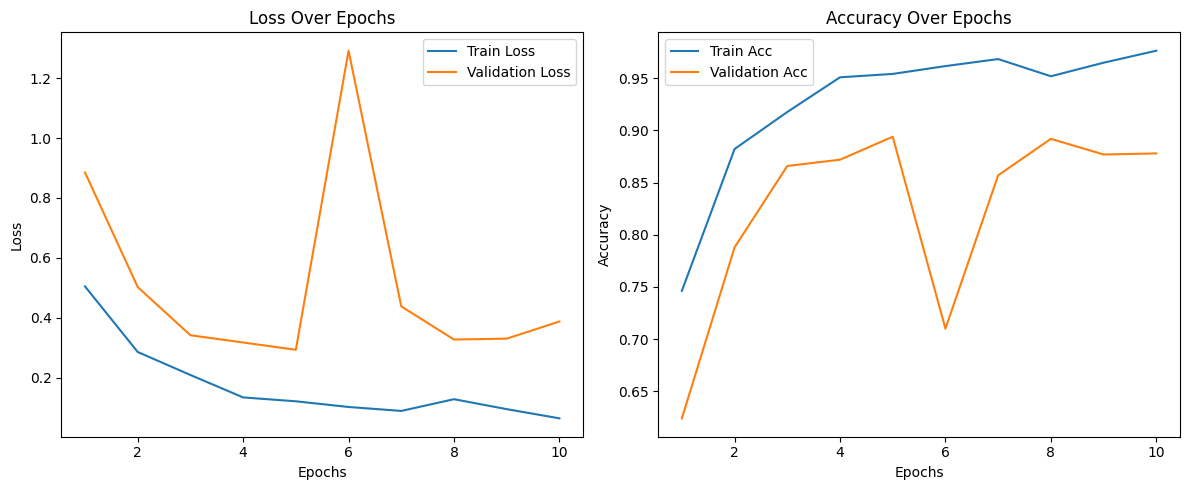

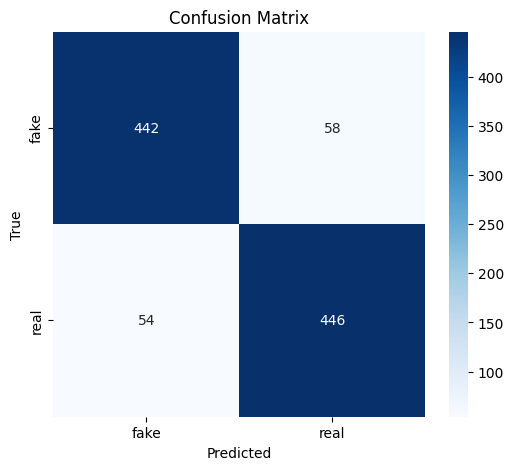

Accuracy: 0.8880
Recall (Sensitivity): 0.8920
F1-score: 0.8884
Specificity: 0.8840


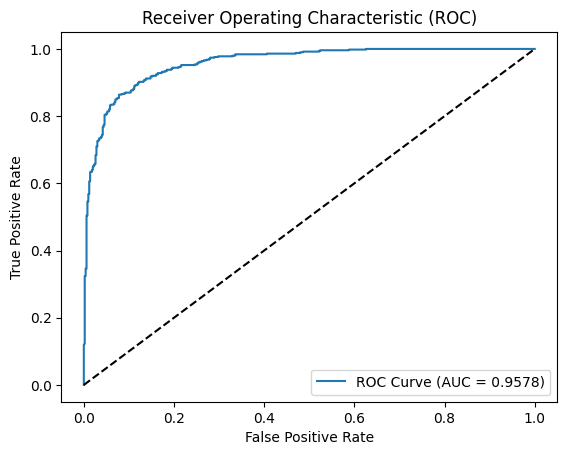

Total Parameters: 4008829
Trainable Parameters: 3157021
Average inference time per image (on 128 images): 0.000267 seconds


In [63]:
# 모델 정의
model = get_efficientnet_b0_partial_tune().to(device)

# 저장된 파라미터 로드
model.load_state_dict(torch.load("checkpoints/efficientnet_b0_partial_3blocks_best.pth", map_location=device))

test_acc, test_loss = test(model, test_loader, device, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Accuracy, Loss 그래프
plot_loss_accuracy(logs)

# Confusion Matrix
plot_confusion_matrix(model, test_loader, device)

# 정밀도/재현율/특이도 등
compute_metrics(model, test_loader, device)

# ROC 곡선
plot_roc_curve(model, test_loader, device)

# 파라미터 개수
count_parameters(model)

# 추론 시간
measure_inference_time_per_image(model, test_loader, device)

In [67]:
def get_efficientnet_b0_partial_tune(n_blocks=4):
    model = models.efficientnet_b0(pretrained=True)

    for param in model.features.parameters():
        param.requires_grad = False

    # features 내부 마지막 n_blocks(3)만 fine-tune
    total_blocks = list(model.features.children())
    for block in total_blocks[-n_blocks:]:
        for param in block.parameters():
            param.requires_grad = True

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 1)

    for param in model.classifier[1].parameters():
        param.requires_grad = True

    return model

In [76]:
from tqdm import tqdm
import os
import numpy as np

EPOCHS = 100
logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

criterion = nn.BCEWithLogitsLoss()
patience = 5
counter = 0
best_loss = np.inf

model = get_efficientnet_b0_fc_bn().to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.007)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(model, train_loader, device, criterion, optimizer)
    val_acc, val_loss = test(model, valid_loader, device, criterion)

    print(f"[Epoch {epoch}] train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f} | "
          f"val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}", flush=True)

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    lr_scheduler.step()

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/efficientnet_b0_partial_4blocks_best.pth")
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        # test_acc, test_loss = test(model, test_loader, device, criterion)
        # print(f"Final Test Accuracy: {test_acc:.4f}")
        break


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 0] train_loss = 0.5250, train_acc = 0.7322 | val_loss = 0.4357, val_acc = 0.7830


  1%|          | 1/100 [00:09<14:58,  9.08s/it]

[Epoch 1] train_loss = 0.3053, train_acc = 0.8655 | val_loss = 0.4267, val_acc = 0.8020


  2%|▏         | 2/100 [00:17<14:36,  8.95s/it]

[Epoch 2] train_loss = 0.2101, train_acc = 0.9095 | val_loss = 0.5340, val_acc = 0.7850


  3%|▎         | 3/100 [00:26<14:25,  8.92s/it]

[Epoch 3] train_loss = 0.1716, train_acc = 0.9317 | val_loss = 0.3765, val_acc = 0.8650


  4%|▍         | 4/100 [00:35<14:23,  9.00s/it]

[Epoch 4] train_loss = 0.1136, train_acc = 0.9537 | val_loss = 0.2863, val_acc = 0.8970


  5%|▌         | 5/100 [00:45<14:18,  9.03s/it]

[Epoch 5] train_loss = 0.0830, train_acc = 0.9675 | val_loss = 0.5776, val_acc = 0.8270


  6%|▌         | 6/100 [00:54<14:13,  9.08s/it]

[Epoch 6] train_loss = 0.0860, train_acc = 0.9688 | val_loss = 0.2839, val_acc = 0.8980


  7%|▋         | 7/100 [01:03<14:06,  9.10s/it]

[Epoch 7] train_loss = 0.0659, train_acc = 0.9755 | val_loss = 0.3832, val_acc = 0.8900


  8%|▊         | 8/100 [01:12<13:57,  9.10s/it]

[Epoch 8] train_loss = 0.0652, train_acc = 0.9740 | val_loss = 0.6820, val_acc = 0.8210


  9%|▉         | 9/100 [01:21<13:40,  9.01s/it]

[Epoch 9] train_loss = 0.0690, train_acc = 0.9752 | val_loss = 0.3124, val_acc = 0.9040


 10%|█         | 10/100 [01:30<13:37,  9.08s/it]

[Epoch 10] train_loss = 0.0491, train_acc = 0.9832 | val_loss = 0.2874, val_acc = 0.9200


 11%|█         | 11/100 [01:39<13:22,  9.01s/it]

[Epoch 11] train_loss = 0.0637, train_acc = 0.9752 | val_loss = 0.4203, val_acc = 0.8930


 11%|█         | 11/100 [01:48<14:35,  9.83s/it]

Early stopping triggered


Final Test Accuracy: 0.9080


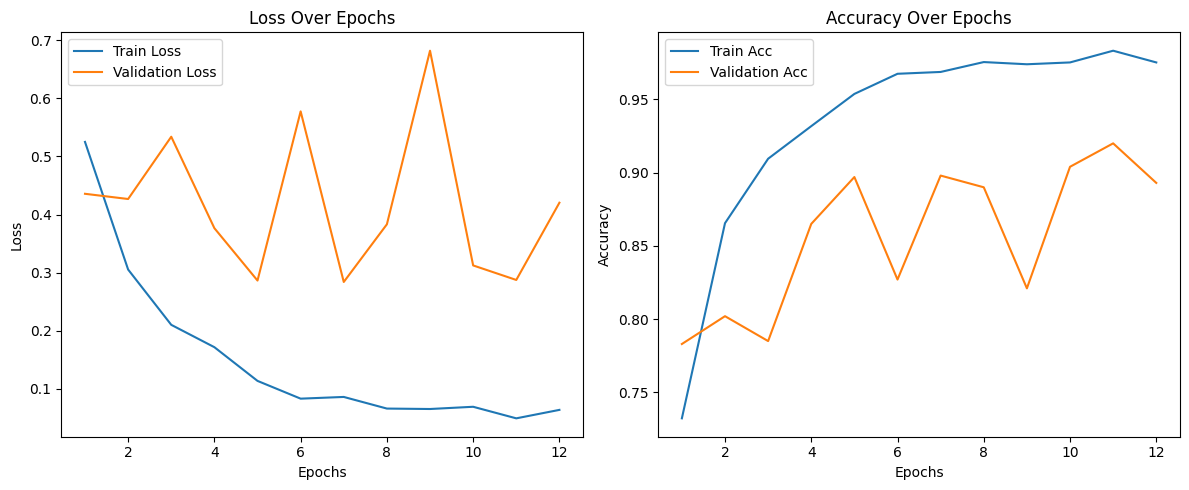

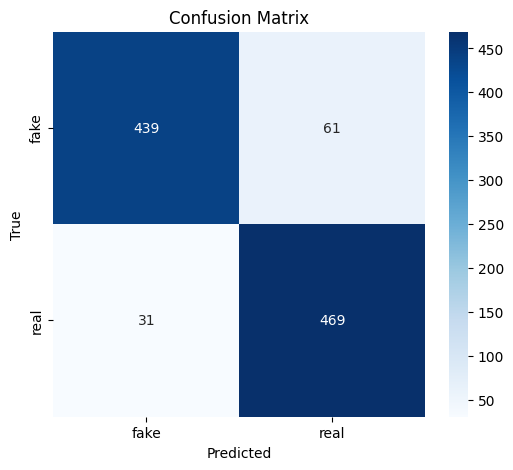

Accuracy: 0.9080
Recall (Sensitivity): 0.9380
F1-score: 0.9107
Specificity: 0.8780


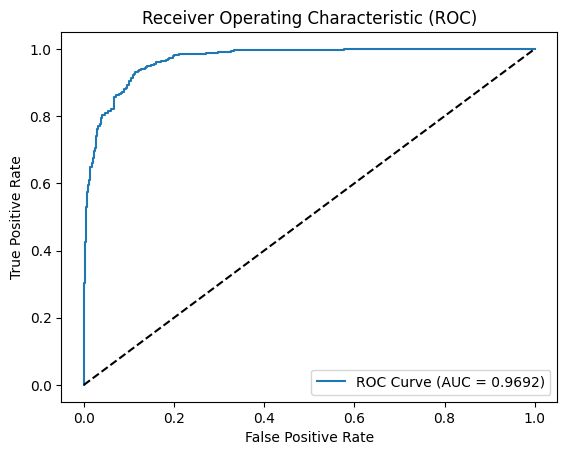

Total Parameters: 4008829
Trainable Parameters: 3700169
Average inference time per image (on 128 images): 0.000311 seconds


In [77]:
# 모델 정의
model = get_efficientnet_b0_partial_tune().to(device)

# 저장된 파라미터 로드
model.load_state_dict(torch.load("checkpoints/efficientnet_b0_partial_4blocks_best.pth", map_location=device))

test_acc, test_loss = test(model, test_loader, device, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Accuracy, Loss 그래프
plot_loss_accuracy(logs)

# Confusion Matrix
plot_confusion_matrix(model, test_loader, device)

# 정밀도/재현율/특이도 등
compute_metrics(model, test_loader, device)

# ROC 곡선
plot_roc_curve(model, test_loader, device)

# 파라미터 개수
count_parameters(model)

# 추론 시간
measure_inference_time_per_image(model, test_loader, device)

#### 전체 fine-tuning

In [78]:
def get_efficientnet_b0_full_finetune():
    model = models.efficientnet_b0(pretrained=True)

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 1)

    for param in model.parameters(): # 전체 레이어
        param.requires_grad = True

    return model

In [89]:
from tqdm import tqdm
import os
import numpy as np

EPOCHS = 100
logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

criterion = nn.BCEWithLogitsLoss()
patience = 5
counter = 0
best_loss = np.inf

model = get_efficientnet_b0_full_finetune().to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(model, train_loader, device, criterion, optimizer)
    val_acc, val_loss = test(model, valid_loader, device, criterion)

    print(f"[Epoch {epoch}] train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f} | "
          f"val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}", flush=True)

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    lr_scheduler.step()

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/efficientnet_b0_full_best.pth")
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        # test_acc, test_loss = test(model, test_loader, device, criterion)
        # print(f"Final Test Accuracy: {test_acc:.4f}")
        break


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 0] train_loss = 0.4261, train_acc = 0.8030 | val_loss = 0.3049, val_acc = 0.8630


  1%|          | 1/100 [00:09<15:06,  9.16s/it]

[Epoch 1] train_loss = 0.1562, train_acc = 0.9383 | val_loss = 0.3408, val_acc = 0.8640


  2%|▏         | 2/100 [00:18<14:54,  9.13s/it]

[Epoch 2] train_loss = 0.1030, train_acc = 0.9640 | val_loss = 0.3023, val_acc = 0.8930


  3%|▎         | 3/100 [00:27<14:38,  9.06s/it]

[Epoch 3] train_loss = 0.0793, train_acc = 0.9700 | val_loss = 0.2776, val_acc = 0.8970


  4%|▍         | 4/100 [00:36<14:31,  9.08s/it]

[Epoch 4] train_loss = 0.0644, train_acc = 0.9778 | val_loss = 0.1674, val_acc = 0.9490


  5%|▌         | 5/100 [00:45<14:23,  9.09s/it]

[Epoch 5] train_loss = 0.0438, train_acc = 0.9852 | val_loss = 0.1987, val_acc = 0.9400


  6%|▌         | 6/100 [00:54<14:06,  9.00s/it]

[Epoch 6] train_loss = 0.0409, train_acc = 0.9852 | val_loss = 0.2568, val_acc = 0.9160


  7%|▋         | 7/100 [01:03<13:57,  9.01s/it]

[Epoch 7] train_loss = 0.0502, train_acc = 0.9828 | val_loss = 0.2161, val_acc = 0.9270


  8%|▊         | 8/100 [01:12<13:48,  9.01s/it]

[Epoch 8] train_loss = 0.0369, train_acc = 0.9870 | val_loss = 0.1459, val_acc = 0.9470


  9%|▉         | 9/100 [01:21<13:44,  9.06s/it]

[Epoch 9] train_loss = 0.0234, train_acc = 0.9918 | val_loss = 0.2594, val_acc = 0.9230


 10%|█         | 10/100 [01:30<13:32,  9.03s/it]

[Epoch 10] train_loss = 0.0191, train_acc = 0.9928 | val_loss = 0.2447, val_acc = 0.9320


 11%|█         | 11/100 [01:39<13:26,  9.06s/it]

[Epoch 11] train_loss = 0.0336, train_acc = 0.9885 | val_loss = 0.2539, val_acc = 0.9250


 12%|█▏        | 12/100 [01:48<13:13,  9.01s/it]

[Epoch 12] train_loss = 0.0226, train_acc = 0.9918 | val_loss = 0.1620, val_acc = 0.9460


 13%|█▎        | 13/100 [01:57<13:09,  9.07s/it]

[Epoch 13] train_loss = 0.0201, train_acc = 0.9942 | val_loss = 0.2030, val_acc = 0.9320


 13%|█▎        | 13/100 [02:06<14:08,  9.75s/it]

Early stopping triggered


Final Test Accuracy: 0.9390


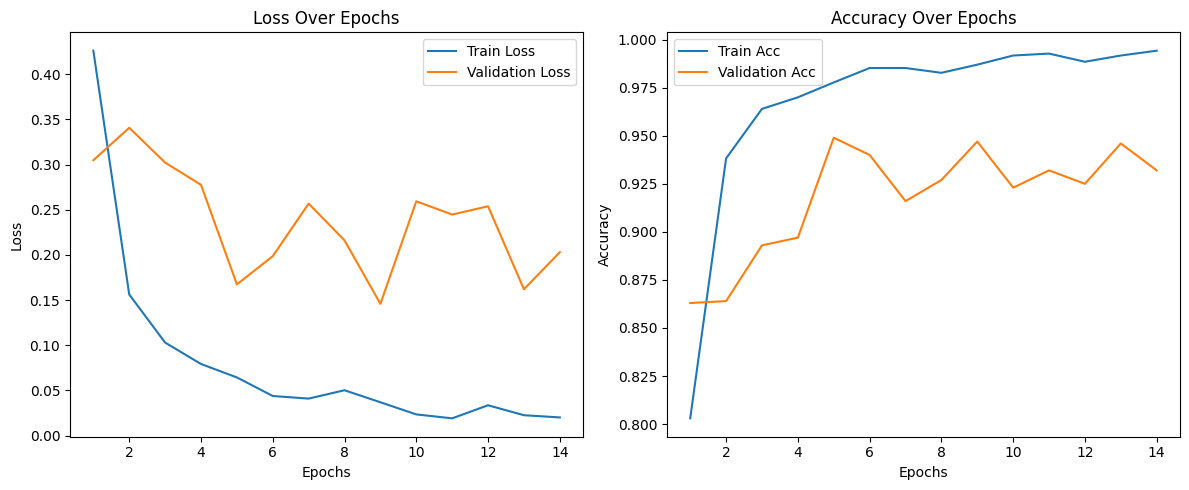

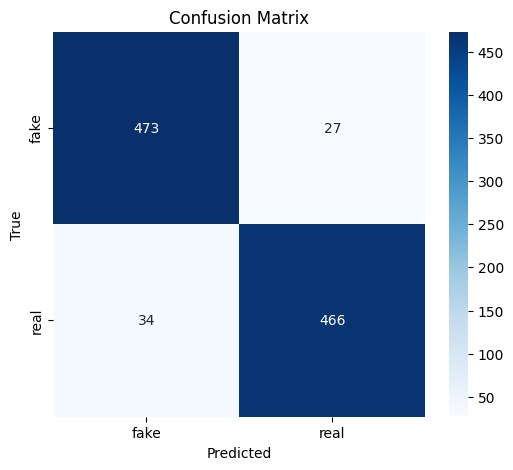

Accuracy: 0.9390
Recall (Sensitivity): 0.9320
F1-score: 0.9386
Specificity: 0.9460


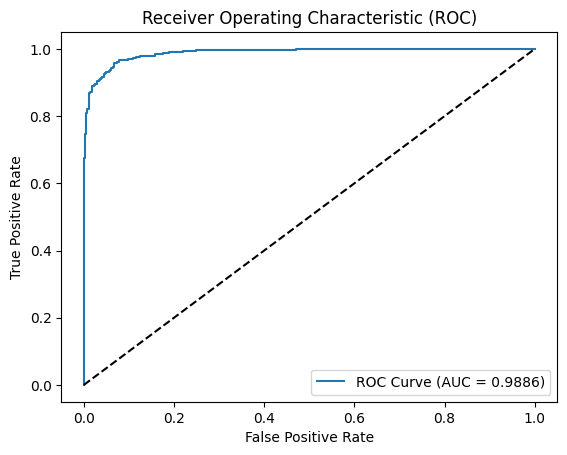

Total Parameters: 4008829
Trainable Parameters: 4008829
Average inference time per image (on 128 images): 0.000357 seconds


In [90]:
# 모델 정의
model = get_efficientnet_b0_full_finetune().to(device)

# 저장된 파라미터 로드
model.load_state_dict(torch.load("checkpoints/efficientnet_b0_full_best.pth", map_location=device))

test_acc, test_loss = test(model, test_loader, device, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Accuracy, Loss 그래프
plot_loss_accuracy(logs)

# Confusion Matrix
plot_confusion_matrix(model, test_loader, device)

# 정밀도/재현율/특이도 등
compute_metrics(model, test_loader, device)

# ROC 곡선
plot_roc_curve(model, test_loader, device)

# 파라미터 개수
count_parameters(model)

# 추론 시간
measure_inference_time_per_image(model, test_loader, device)

#### Grad-CAM

In [91]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.4 MB

In [97]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_state_dict = torch.load("checkpoints/efficientnet_b0_full_best.pth", map_location=device)
model = get_efficientnet_b0_fc_only()
model.load_state_dict(model_state_dict)
model.to(device)
model.eval()

# 마지막 Convolution layer 설정
# target_layer = model.features[-1][0]
target_layer = None
for layer in reversed(list(model.features.children())):
    if isinstance(layer, nn.Sequential):
        for sublayer in reversed(list(layer.children())):
            if isinstance(sublayer, nn.Conv2d):
                target_layer = sublayer
                break
        if target_layer:
            break

assert target_layer is not None, "Conv2d target_layer not found. Check model structure."


# Grad-CAM 객체 생성
cam = GradCAM(model=model, target_layers=[target_layer])

# Normalize 해제 (ImageNet 기준일 경우)
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

def show_gradcam_examples():
    fake_imgs = []
    real_imgs = []

    # 15장씩 수집
    for images, labels in test_loader:
        for img, label in zip(images, labels):
            if label.item() == 0 and len(fake_imgs) < 15:
                fake_imgs.append(img)
            elif label.item() == 1 and len(real_imgs) < 15:
                real_imgs.append(img)
            if len(fake_imgs) == 15 and len(real_imgs) == 15:
                break
        if len(fake_imgs) == 15 and len(real_imgs) == 15:
            break

    all_imgs = fake_imgs + real_imgs
    all_labels = [0]*15 + [1]*15
    all_titles = [f"Fake{i+1}" for i in range(15)] + [f"Real{i+1}" for i in range(15)]

    plt.figure(figsize=(24, 14))  # 넓은 캔버스 확보

    with GradCAM(model=model, target_layers=[target_layer]) as cam:
        for idx, (img, label, title) in enumerate(zip(all_imgs, all_labels, all_titles)):
            input_tensor = img.unsqueeze(0).to(device)
            targets = [BinaryClassifierOutputTarget(label)]

            grayscale_cam = cam(
                input_tensor=input_tensor,
                targets=targets,
                eigen_smooth=True,
                aug_smooth=True
            )[0]

            img_np = inv_normalize(img).permute(1, 2, 0).cpu().numpy()
            img_np = np.clip(img_np, 0, 1)
            cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

            # 행/열 위치 계산
            group_idx = idx % 15
            row_offset = 0 if label == 0 else 3  # Fake: 위, Real: 아래
            col = (group_idx % 5) * 2
            row = row_offset + (group_idx // 5)

            # Overlay
            plt.subplot(6, 10, row * 10 + col + 1)
            plt.imshow(cam_image)
            plt.title(title, fontsize=8)
            plt.axis('off')

            # CAM heatmap
            plt.subplot(6, 10, row * 10 + col + 2)
            plt.imshow(grayscale_cam, cmap='jet')
            plt.title(f"{title} CAM", fontsize=8)
            plt.axis('off')

    plt.tight_layout(h_pad=1.5, w_pad=0.5)
    plt.subplots_adjust(top=0.95, bottom=0.05)
    plt.show()

# 실행
show_gradcam_examples()

AttributeError: 'NoneType' object has no attribute 'shape'

<Figure size 2400x1400 with 0 Axes>

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torch

model_state_dict = torch.load("checkpoints/efficientnet_b0_full_best.pth")
model = get_efficientnet_b0_fc_only()
model.load_state_dict(model_state_dict)

# 마지막 Convolution layer 설정
target_layer = model.features[-1]

# Grad-CAM 객체 생성
cam = GradCAM(model=model, target_layers=[target_layer])

# Normalize 해제 (ImageNet 기준일 경우)
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

def show_gradcam_examples():
    fake_imgs = []
    real_imgs = []

    # 15장씩 수집
    for images, labels in test_loader:
        for img, label in zip(images, labels):
            if label.item() == 0 and len(fake_imgs) < 15:
                fake_imgs.append(img)
            elif label.item() == 1 and len(real_imgs) < 15:
                real_imgs.append(img)
            if len(fake_imgs) == 15 and len(real_imgs) == 15:
                break
        if len(fake_imgs) == 15 and len(real_imgs) == 15:
            break

    all_imgs = fake_imgs + real_imgs
    all_labels = [0]*15 + [1]*15
    all_titles = [f"Fake{i+1}" for i in range(15)] + [f"Real{i+1}" for i in range(15)]

    plt.figure(figsize=(24, 14))  # 넓은 캔버스 확보

    with GradCAM(model=model, target_layers=[target_layer]) as cam:
        for idx, (img, label, title) in enumerate(zip(all_imgs, all_labels, all_titles)):
            input_tensor = img.unsqueeze(0).to(device)
            targets = [BinaryClassifierOutputTarget(label)]

            grayscale_cam = cam(
                input_tensor=input_tensor,
                targets=targets,
                eigen_smooth=True,
                aug_smooth=True
            )[0]

            # L2 정규화 적용
            grayscale_cam = grayscale_cam / np.sqrt(np.sum(grayscale_cam ** 2) + 1e-8)

            img_np = inv_normalize(img).permute(1, 2, 0).cpu().numpy()
            img_np = np.clip(img_np, 0, 1)
            cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

            # 행/열 위치 계산
            group_idx = idx % 15
            row_offset = 0 if label == 0 else 3  # Fake: 위, Real: 아래
            col = (group_idx % 5) * 2
            row = row_offset + (group_idx // 5)

            # Overlay
            plt.subplot(6, 10, row * 10 + col + 1)
            plt.imshow(cam_image)
            plt.title(title, fontsize=8)
            plt.axis('off')

            # CAM heatmap
            plt.subplot(6, 10, row * 10 + col + 2)
            plt.imshow(grayscale_cam, cmap='jet')
            plt.title(f"{title} CAM", fontsize=8)
            plt.axis('off')

    plt.tight_layout(h_pad=1.5, w_pad=0.5)
    plt.subplots_adjust(top=0.95, bottom=0.05)
    plt.show()

# 실행
show_gradcam_examples()